In [1]:
from epymetheus import Trade, TradeHistory, TradeStrategy, Universe, Transaction, Backtester
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pathlib
from dateutil.relativedelta import relativedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn
seaborn.set_style('ticks')

In [13]:
class SimpleMeanReversion(TradeStrategy):
    """
    A simple Mean Reversion strategy that buys stocks for a month with
    the lowest percentile one month returns and sells the highest percentile returns.

    Parameters
    ----------
    - percentile : float
        The threshold to buy or sell.
        E.g. If 0.1, buy/sell stocks with returns of lowest/highest 10%.
    """
    # XXX changed to trend follow

    def logic(self, universe, percentile):

        train_period = relativedelta(months=1)
        trade_period = relativedelta(months=1)

        def trade_bds(universe, train_period, trade_period):
            """Yield begin dates of trade periods."""
            d = universe.begin_date + train_period
            while d + trade_period <= universe.end_date:
                yield d
                d += trade_period

        def tot_return(asset, begin_date, end_date):
            """Return total return of asset from begin_date to end_date."""
            b, e = universe.data.at[begin_date, asset], universe.data.at[end_date, asset]
            return e / b - 1

        num_buysell = int(len(universe.data.columns) * percentile)

        for trade_bd in trade_bds(universe, train_period, trade_period):
            train_bd = trade_bd - train_period
            trade_ed = trade_bd + trade_period - relativedelta(days=1)
            train_ed = train_bd + train_period - relativedelta(days=1)

            key = lambda asset: tot_return(asset, train_bd, train_ed)
            sell = sorted(universe.data.columns, key=key)[:num_buysell]
            buy = sorted(universe.data.columns, key=key)[-num_buysell:]
            
            for asset in sell:
                lot = 1.0 / universe.data.at[trade_bd, asset]
                yield Trade(asset=asset, lot=lot, begin_date=trade_bd, end_date=trade_ed)
            
            for asset in buy:
                lot = -1.0 / universe.data.at[trade_bd, asset]
                yield Trade(asset=asset, lot=lot, begin_date=trade_bd, end_date=trade_ed)

In [14]:
csvs = pathlib.Path('../data/JP Equity').glob('*.csv')

universe = Universe.read_csvs(
    name='JP Equity', csvs=csvs, index_col=0, parse_dates=True,
    begin_date=datetime.date(2000, 1, 1), 
    end_date=datetime.date(2018, 12, 31)
)

universe.data.dropna(axis=1, how='any', inplace=True)
universe.data.head()

,8802,7267,2914,8031,6752,4452,9984,7203,6861,6501,...,9432,4502,7751,4503,9437,7974,8058,6954,6981,6758
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1075.5,2092.8,815.3,802.7,3097.0,3222.8,5485.3,5565.2,13049.3,9613.4,...,9376.4,5554.9,2988.6,772.5,7868.5,18667.9,865.4,13753.6,8563.2,16817.5
2000-01-02,1075.5,2092.8,815.3,802.7,3097.0,3222.8,5485.3,5565.2,13049.3,9613.4,...,9376.4,5554.9,2988.6,772.5,7868.5,18667.9,865.4,13753.6,8563.2,16817.5
2000-01-03,1075.5,2092.8,815.3,802.7,3097.0,3222.8,5485.3,5565.2,13049.3,9613.4,...,9376.4,5554.9,2988.6,772.5,7868.5,18667.9,865.4,13753.6,8563.2,16817.5
2000-01-04,1094.9,2109.3,784.0,822.9,3179.1,3167.5,5776.9,5554.0,12137.4,9906.5,...,9590.8,5114.9,3018.0,737.8,7908.5,17603.0,890.6,12580.1,8006.6,17039.5
2000-01-05,1031.3,2076.3,785.0,864.5,3031.3,3062.5,4857.1,5497.8,11194.1,9232.4,...,9215.7,5081.9,2848.7,783.3,7147.7,17636.3,875.3,11248.1,8006.6,15374.4


In [15]:
strategy = SimpleMeanReversion(percentile=0.1)

In [16]:
backtester = Backtester()

backtester.run(strategy, universe, verbose=True)

Generating trades ...
Evaluating wealth ...
Done.
Runtime : 4.2sec


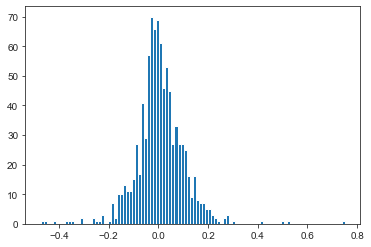

In [17]:
plt.hist(backtester.history_.data['gain'], bins=100)
plt.show()

In [18]:
backtester.history_.data

,asset,lot,begin_date,end_date,duration,gain
0,6954,0.000083,2000-02-01,2000-02-29,28 days,-0.058105
1,9433,0.000488,2000-02-01,2000-02-29,28 days,-0.157008
2,4063,-0.000169,2000-02-01,2000-02-29,28 days,-0.060616
3,4503,-0.000961,2000-02-01,2000-02-29,28 days,-0.091468
4,9433,0.000574,2000-03-01,2000-03-31,30 days,-0.184618
...,...,...,...,...,...,...
899,8058,-0.000167,2018-10-01,2018-10-31,30 days,0.105483
900,9984,0.000220,2018-11-01,2018-11-30,29 days,0.146331
901,4452,0.000086,2018-11-01,2018-11-30,29 days,0.102202
902,6981,-0.000115,2018-11-01,2018-11-30,29 days,0.080701


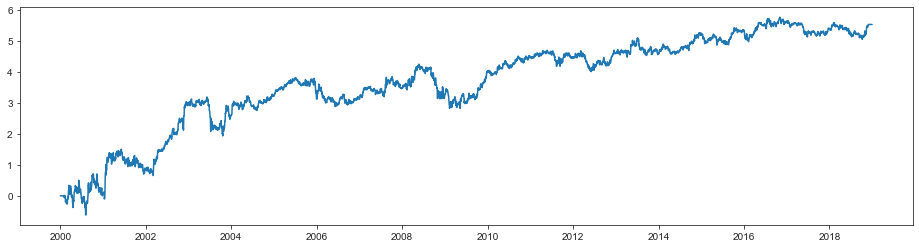

In [19]:
plt.figure(figsize=(16, 4))
plt.plot(backtester.wealth_.data)
plt.show()

In [20]:
t = backtester.transaction_.data
u = universe.data

In [10]:
p = t.shift().cumsum()
p = p.reindex(u.index).fillna(method='ffill').fillna(0.0)

w = (p * u.diff()).cumsum().sum(axis=1)

p_ = p.loc['2017-12-01':]
# p_

In [11]:
u_ = u.loc['2017-12-01':].diff()
u_

,8802,7267,2914,8031,6752,4452,9984,7203,6861,6501,...,9432,4502,7751,4503,9437,7974,8058,6954,6981,6758
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-04,-8.0,18.1,-29.0,-4.3,-27.5,4.5,-54.5,-67.8,-1416.9,-47.3,...,-43.8,-12.7,13.7,23.5,-40.0,-1258.8,26.0,-737.1,-83.7,94.2
2017-12-05,26.4,-30.1,91.2,18.2,-16.8,233.1,-37.0,-17.3,-304.4,36.9,...,136.0,-34.6,-6.8,-18.1,-6.1,-2102.9,74.6,-690.7,-74.6,-49.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,79.3,180.1,147.1,179.7,70.2,752.0,182.1,437.5,3629.5,181.6,...,316.2,139.6,166.7,77.7,165.7,1795.2,281.1,331.0,319.8,359.8
2018-12-28,-22.5,-3.1,16.3,21.8,2.1,-75.8,13.7,-14.6,-810.0,-10.6,...,-9.6,-164.1,-12.8,-64.9,-31.9,-37.5,-3.4,351.7,-34.5,-74.3
2018-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


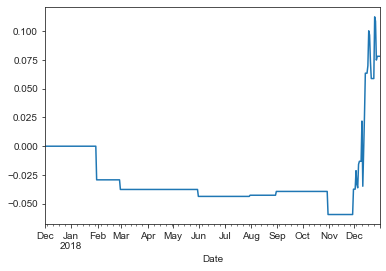

In [12]:
(p_ * u_).cumsum().sum(axis=1).plot()